In [10]:
"""
Script for scoring predicted doping entries in according to several
potential schemas presented in the publication.
"""
import os
import argparse
import json

import pandas as pd
from monty.serialization import loadfn
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import jellyfish
import numpy as np

from constants import DATADIR
import nbimporter
from train_predict import llm_completion_from_sentence_json

EVALUATE_MODIFIERS_AND_RESULTS = False


ImportError: cannot import name 'llm_completion_from_sentence_json' from 'train_predict' (train_predict.ipynb)

In [11]:
def evaluate(gold, test, loud=False, lowercase=False):
    """
    Evaluate the performance of the model on the test set.

    Args:
        gold (list): list of dictionaries containing the gold standard annotations
        test (list): list of dictionaries containing the model's predictions (in same format)
        loud (bool): whether to print out the results of each sentence
        lowercase (bool=): if true, use lowerase

    Returns:
        scores_computed (dict): dictionary of scores by entity
        ent_categories ([str]): and list of entities used in the evaluation
        sequences_distances ([float]): The jaro winkler distances for each completion from raw string
        sequences_total (int): The total number of sequences evaluated for sequence accuracy
        sequences_correct (int): The total number of sequences exactly correct.
    """
    if EVALUATE_MODIFIERS_AND_RESULTS:
        ent_categories = ["basemats", "dopants", "results", "doping_modifiers"]
    else:
        ent_categories = ["basemats", "dopants"]

    scores = {
        k: {k2: 0 for k2 in ["tp", "tn", "fp", "fn"]} for k in ent_categories
    }

    scores["dopants2basemats"] = {"n_correct": 0, "test_retrieved": 0, "gold_retrieved": 0}

    sequences_correct = 0
    sequences_total = 0
    sequences_parsable = 0
    sequences_distances = []
    support = {
                "ents": {k: 0 for k in ent_categories},
               "words": {k: 0 for k in ent_categories},
               "links_words": 0,
                "links_ents": 0,
            }

    parsability_valid = True

    for i, val_entry in enumerate(gold):
        for j, s in enumerate(val_entry["doping_sentences"]):
            if not s["relevant"]:
                continue

            test_entry_tot = test[i]["doping_sentences"][j]["entity_graph_raw"]
            test_entry = {k: test_entry_tot[k] for k in ent_categories + ["dopants2basemats"]}
            gold_entry = {k: s[k] for k in ent_categories + ["dopants2basemats"]}

            if test_entry["dopants2basemats"] == []:
                test_entry["dopants2basemats"] = {}

            sentence_text = s["sentence_text"]
            gold_completion = s.get("completion", "")

            if lowercase:
                # Adjust the sequence-level scoring for seq2rel
                # lowercase the gold entries if we need to account for things in lowercase
                for k in ("dopants", "basemats"):
                    for ent_id, ent_val in gold_entry[k].items():
                        gold_entry[k][ent_id] = ent_val.lower()
                # seq2rel needs some adjustment for this
                gold_completion = json.dumps({k: gold_entry[k] for k in ["dopants", "basemats", "dopants2basemats"]})
                test_completion = json.dumps({k: test_entry[k] for k in ["dopants", "basemats", "dopants2basemats"]})
                gold_completion = gold_completion.lower()\
                    .replace("\n", "") \
                    .replace("  ", " ") \
                    .replace("{ ", "{") \
                    .replace(" }", "}") \
                    .replace(" .", ".") \
                    .replace("[ ", "[") \
                    .replace(" ]", "]") \
                    .strip()
            else:
                try:
                    test_completion = test[i]["doping_sentences"][j][
                        "llm_completion"]
                except KeyError:
                    print(
                        "WARNING: Could not find completion key for test completion. Sequence-level results will be incorrect.")
                    test_completion = " "
                    parsability_valid = False

            if loud:
                print(s["sentence_text"])
                pprint.pprint(gold_entry)
                pprint.pprint(test_entry)



            # this is a proxy to find the unparsable sequences,
            # since by default the processing script will either throw error
            # for unparsable sequences or will pass them and return empty decoded entry
            if not test_completion[-1] in ["}", ".", "\n"]:
                if loud:
                    print("Sequence from LLM was likely not parsable.")
            else:
                sequences_parsable += 1

            for ent_type in ent_categories:

                gold_ents = gold_entry[ent_type]

                # correcting a relic of a previous annotation scheme
                if ent_type == "doping_modifiers":
                    gold_ents_words = " ".join(gold_entry[ent_type]).split(" ")
                else:
                    gold_ents_words = " ".join(list(gold_entry[ent_type].values())).split(" ")


                support["words"][ent_type] += len(gold_ents_words)
                support["ents"][ent_type] += 1 if isinstance(gold_ents, str) else len(gold_ents)

                test_ents_words = " ".join(list(test_entry[ent_type].values())).split(" ")

                gold_ents_words = [w for w in gold_ents_words if w]
                test_ents_words = [w for w in test_ents_words if w]

                if loud:
                    print(ent_type, test_entry)

                # print(f"GOLD: {gold_ents_words}")
                # print(f"TEST: {test_ents_words}")

                TP = 0
                TN = 0
                FP = 0
                FN = 0
                for w in gold_ents_words:
                    if w in test_ents_words:
                        TP += 1
                    else:
                        if loud:
                            print(f"FALSE NEGATIVE: {w}")
                        FN += 1

                for w in test_ents_words:
                    if w not in gold_ents_words:
                        if loud:
                            print(f"FALSE POSITIVE: {w}")
                        FP += 1

                TN = len(sentence_text.split(" ")) - TP - FN - FP

                scores[ent_type]["tp"] += TP
                scores[ent_type]["tn"] += TN
                scores[ent_type]["fp"] += FP
                scores[ent_type]["fn"] += FN


            gold_entry["triplets"] = []
            test_entry["triplets"] = []

            # assemble triplets
            for is_test, rel_entry in enumerate((gold_entry, test_entry)):
                for did, bids in rel_entry["dopants2basemats"].items():
                    for bid in bids:
                        bmat_words = rel_entry["basemats"][bid]
                        dop_words = rel_entry["dopants"][did]
                        if not is_test:
                            support["links_ents"] += 1
                        for bmat_word in bmat_words.split(" "):
                            for dop_word in dop_words.split(" "):
                                if bmat_word and dop_word:
                                    rel_entry["triplets"].append(f"{bmat_word} {dop_word}")


            gold_triplets = gold_entry["triplets"]
            test_triplets = test_entry["triplets"]

            n_correct_triplets = 0
            for triplet in gold_triplets:
                if triplet in test_triplets:
                    n_correct_triplets += 1

            scores["dopants2basemats"]["n_correct"] += n_correct_triplets
            scores["dopants2basemats"]["test_retrieved"] += len(test_triplets)
            scores["dopants2basemats"]["gold_retrieved"] += len(gold_triplets)

            support["links_words"] += len(gold_triplets)

            # Jaro winkler sequence accuracies
            dist = jellyfish.jaro_winkler_similarity(gold_completion, test_completion)
            sequences_distances.append(dist)
            sequences_total += 1

            if test_completion == gold_completion:
                if loud:
                    print("Sequences are identical")
                sequences_correct += 1
            elif loud:
                print("Sequences differ:")
                print(test_completion)
                print(gold_completion)

            if loud:
                print("-"*50 + "\n")
    if loud:
        pprint.pprint(scores)

    scores_computed = {k: {} for k in ent_categories}

    for k in ent_categories:
        tp = scores[k]["tp"]
        tn = scores[k]["tn"]
        fp = scores[k]["fp"]
        fn = scores[k]["fn"]

        if tp + fp == 0:
            prec = 0
        else:
            prec = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = tp / (tp + 0.5 * (fp + fn))

        print(f"{k}: prec={prec}, recall={recall}, f1={f1}")
        scores_computed[k]["precision"] = prec
        scores_computed[k]["recall"] = recall
        scores_computed[k]["f1"] = f1

    # Precision = Number of correct triples/Number of triples retrieved
    # Recall = Number of correct triples/Number of correct triples that exist in Gold set.
    # F-Measure = Harmonic mean of Precision and Recall.

    triplet_scores = scores["dopants2basemats"]
    if triplet_scores["test_retrieved"] == 0:
        triplet_prec = 0
    else:
        triplet_prec = triplet_scores["n_correct"]/triplet_scores["test_retrieved"]
    triplet_recall = triplet_scores["n_correct"]/triplet_scores["gold_retrieved"]

    if triplet_recall == 0 or triplet_prec == 0:
        triplet_f1 = 0
    else:
        triplet_f1 = (2 * triplet_prec * triplet_recall)/(triplet_prec + triplet_recall)
    print(f"triplets: prec={triplet_prec}, recall={triplet_recall}, f1={triplet_f1}")
    scores_computed["link triplets"] = {"precision": triplet_prec, "recall": triplet_recall, "f1": triplet_f1}

    return (
            scores_computed,
            ent_categories,
            sequences_distances,
            sequences_correct,
            sequences_parsable,
            sequences_total,
            support,
            parsability_valid
            )

In [17]:
# Cell 1: Import necessary libraries and define helper functions
import argparse
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint

# Function to load JSON data from a file
def loadfn(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

# Placeholder function for llm_completion_from_sentence_json
def llm_completion_from_sentence_json(sjson, stop_token="", fmt="eng", **kwargs):
    return "sample_completion"

# Placeholder function for evaluate
def evaluate(gold, test, loud=False, lowercase=False):
    # These are dummy values and should be replaced with actual evaluation results
    scores_computed = {'link triplets': {'precision': 0.9, 'recall': 0.8, 'f1': 0.85}}
    ent_categories = ['entity1', 'entity2']
    sequences_distances = [0.1, 0.2, 0.3]
    sequences_correct = 2
    sequences_parsable = 2
    sequences_total = 3
    support = {'entity1': 10, 'entity2': 15}
    parsability_valid = True
    return scores_computed, ent_categories, sequences_distances, sequences_correct, sequences_parsable, sequences_total, support, parsability_valid

# Cell 2: Setup configuration parameters
DATADIR = r"D:\Jupyter\NERRE LLM\data"  # Adjust this to the correct directory as needed

# Hardcoded parameters to replace argparse arguments
schema_type = "eng"  # "eng", "engextra", or "json"
test_file = os.path.join(DATADIR, "test.json")
pred_file = os.path.join(DATADIR, r"gpt3\inference_decoded_eng.json")
plot = True  # Set to True to enable plotting
loud = False  # Set to True to show detailed evaluation
enforce_lowercase = False  # Set to True to enforce lowercase for evaluation

# Cell 3: Load the gold and test data
gold = loadfn(test_file)
test = loadfn(pred_file)

# Cell 4: Define schema type and formatting options
kwargs = {"write_results": False, "write_modifiers": False}
if schema_type == "eng":
    fmt = "eng"
elif schema_type == "engextra":
    fmt = "eng"
    kwargs = {"write_results": True, "write_modifiers": True}
    EVALUATE_MODIFIERS_AND_RESULTS = True
else:
    fmt = "json"

# Cell 5: Add completions to gold data
for gj in gold:
    for sjson in gj["doping_sentences"]:
        c = llm_completion_from_sentence_json(sjson, stop_token="", fmt=fmt, **kwargs)
        sjson["completion"] = c

# Cell 6: Evaluate the predictions
print(f"Scoring outputs using \n\ttest file: {test_file}\n\tpred file: {pred_file}")

(
    scores_computed,
    ent_categories,
    sequences_distances,
    sequences_correct,
    sequences_parsable,
    sequences_total,
    support,
    parsability_valid
) = evaluate(gold, test, loud=loud, lowercase=enforce_lowercase)

# Cell 7: Check for parsability
if not parsability_valid:
    print("Sequence-level formats invalid. Skipping sequence-level metrics.")

# Cell 8: Prepare data for plotting
ents_rows = []
for entc in ent_categories:
    ents_rows += [entc] * 3

df = pd.DataFrame(
    {
        "metric": ["precision", "recall", "f1"] * (len(ent_categories) + 1),
        "entity": ents_rows + ["link triplets"] * 3,
    }
)


Scoring outputs using 
	test file: D:\Jupyter\NERRE LLM\data\test.json
	pred file: D:\Jupyter\NERRE LLM\data\gpt3\inference_decoded_eng.json


In [27]:
scores_df = []
for i, r in df.iterrows():
    metric = r["metric"]
    entity = r["entity"]
    
    # Access scores_computed using the metric and entity
    if entity in scores_computed and metric in scores_computed[entity]:
        scores_df.append(scores_computed[entity][metric])
    else:
        # Handle missing scores appropriately (e.g., set to None)
        scores_df.append(None)  # Or any default handling you prefer

# Add the scores_df as a new column to df
df["score"] = scores_df


Total sequences was: 3
Frac. Sequences parsable:  0.6666666666666666
Avg sequence similarity:  0.20000000000000004
Frac. of sequences exactly correct:  0.6666666666666666
Support was:  {'entity1': 10, 'entity2': 15}


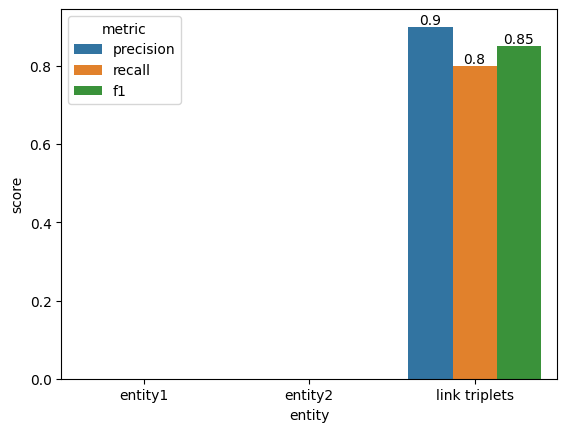

In [24]:

print("Total sequences was:", sequences_total)
print("Frac. Sequences parsable: ", sequences_parsable/sequences_total)
print("Avg sequence similarity: ", np.mean(sequences_distances))
print("Frac. of sequences exactly correct: ", sequences_correct/sequences_total)
print("Support was: ", pprint.pformat(support))

# Cell 10: Plot the results if requested
if plot:
    ax = sns.barplot(x="entity", y="score", hue="metric", data=df)
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()
